# This is an implementation of a neural network using only raw python and numpy
* The network is trained on the cats and dogs dataset
* The network has 4 hidden layers with 20 neurons each

Coding the neural network from scratch is a by no means a good idea for real world applications. However, it is a good way to understand the inner workings of a neural network. This notebook is a good starting point for anyone who wants to learn about neural networks.


In [9]:
import numpy as np

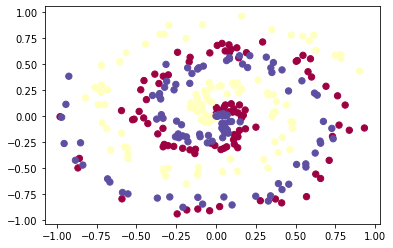

In [10]:
def create_data(points, classes):
    X = np.zeros((points*classes, 2))
    y = np.zeros(points*classes, dtype='uint8')
    for class_number in range(classes):
        ix = range(points*class_number, points*(class_number+1))
        r = np.linspace(0.0, 1, points) # radius
        t = np.linspace(class_number*4, (class_number+1)*4, points) + np.random.randn(points)*0.2 # theta
        X[ix] = np.c_[r*np.sin(t*2.5), r*np.cos(t*2.5)]
        y[ix] = class_number
    return X, y

import matplotlib.pyplot as plt
X, y = create_data(100, 3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)

### Layer class

In [11]:
np.random.seed(0)

class Layer_Dense:

    # Layer initialization
    def __init__(self, n_inputs, n_neurons):
        #   ,
        #          weight_regularizer_l1=0, weight_regularizer_l2=0,
        #          bias_regularizer_l1=0, bias_regularizer_l2=0):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        # Set regularization strength
        # self.weight_regularizer_l1 = weight_regularizer_l1
        # self.weight_regularizer_l2 = weight_regularizer_l2
        # self.bias_regularizer_l1 = bias_regularizer_l1
        # self.bias_regularizer_l2 = bias_regularizer_l2

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)


        # # Gradients on regularization
        # # L1 on weights
        # if self.weight_regularizer_l1 > 0:
        #     dL1 = np.ones_like(self.weights)
        #     dL1[self.weights < 0] = -1
        #     self.dweights += self.weight_regularizer_l1 * dL1
        # # L2 on weights
        # if self.weight_regularizer_l2 > 0:
        #     self.dweights += 2 * self.weight_regularizer_l2 * \
        #                      self.weights
        # # L1 on biases
        # if self.bias_regularizer_l1 > 0:
        #     dL1 = np.ones_like(self.biases)
        #     dL1[self.biases < 0] = -1
        #     self.dbiases += self.bias_regularizer_l1 * dL1
        # # L2 on biases
        # if self.bias_regularizer_l2 > 0:
        #     self.dbiases += 2 * self.bias_regularizer_l2 * \
        #                     self.biases

        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)

The `__init__` method takes in two parameters, `n_inputs` and `n_neurons`. `n_inputs` is the number of input neurons, and `n_neurons` is the number of neurons in this layer.

In this method, the weights and biases of the layer are initialized. The weights are initialized randomly using the `np.random.randn` function. The shape of the weights matrix is `(n_inputs, n_neurons)`. The biases are initialized to zeros with a shape of `(1, n_neurons)`.

The `forward` method is the implementation of the forward pass for this layer. It takes in inputs, which is a matrix of shape `(batch_size, n_inputs)`. The output of this layer is calculated by taking the dot product of inputs and weights, and then adding the biases. The output of this layer has a shape of `(batch_size, n_neurons)`.

The `backward` method in this code is responsible for computing the gradients of the loss with respect to the weights, biases, and inputs of a layer. This is an important step in the process of training a neural network using gradient descent.

The `dvalues` parameter represents the derivative of the loss with respect to the output of the layer, which is passed in from the subsequent layer during backpropagation.

The method first computes the gradients of the loss with respect to the weights and biases using the chain rule of calculus. The `dweights` are computed as the dot product between the transpose of the input values and the `dvalues`. This results in a matrix of the same shape as the `weights` matrix, representing the gradient of the loss with respect to each weight parameter.

Similarly, the `dbiases` are computed by summing the `dvalues` along the rows (axis=0) and keeping the dimensions consistent with the `biases` matrix.

Finally, the gradient of the loss with respect to the inputs is computed as the dot product between the `dvalues` and the transpose of the `weights`. This allows the gradient to be propagated backwards through the network to update the weights of the previous layer.

Overall, the `backward` method is a crucial step in the backpropagation algorithm for training neural networks, and this implementation computes the gradients efficiently using matrix operations.


In summary, this class implements a dense layer in a neural network with `n_inputs` input neurons and `n_neurons` output neurons. The weights and biases are randomly initialized, and the forward pass is calculated by taking the dot product of the inputs and weights, and adding biases. The backward pass computes the gradients of the loss with respect to the weights, biases, and inputs of the layer.

In [12]:
# ReLU activation
class Activation_ReLU:

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify original variable,
        # let's make a copy of values first
        self.dinputs = dvalues.copy()

        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0



# Softmax activation
class Activation_Softmax:

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs

        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                            keepdims=True))
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,
                                            keepdims=True)

        self.output = probabilities

    # Backward pass
    def backward(self, dvalues):

        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in \
                enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)

            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - \
                              np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix,
                                         single_dvalues)


# Sigmoid activation
class Activation_Sigmoid:

    # Forward pass
    def forward(self, inputs):
        # Save input and calculate/save output
        # of the sigmoid function
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))

    # Backward pass
    def backward(self, dvalues):
        # Derivative - calculates from output of the sigmoid function
        self.dinputs = dvalues * (1 - self.output) * self.output


In [13]:
# SGD optimizer
class Optimizer_SGD:

    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))


    # Update parameters
    def update_params(self, layer):

        # If we use momentum
        if self.momentum:

            # If layer does not contain momentum arrays, create them
            # filled with zeros
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                # If there is no momentum array for weights
                # The array doesn't exist for biases yet either.
                layer.bias_momentums = np.zeros_like(layer.biases)

            # Build weight updates with momentum - take previous
            # updates multiplied by retain factor and update with
            # current gradients
            weight_updates = \
                self.momentum * layer.weight_momentums - \
                self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            # Build bias updates
            bias_updates = \
                self.momentum * layer.bias_momentums - \
                self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates

        # Vanilla SGD updates (as before momentum update)
        else:
            weight_updates = -self.current_learning_rate * \
                             layer.dweights
            bias_updates = -self.current_learning_rate * \
                           layer.dbiases

        # Update weights and biases using either
        # vanilla or momentum updates
        layer.weights += weight_updates
        layer.biases += bias_updates

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# Adam optimizer
class Optimizer_Adam:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
                 beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update momentum  with current gradients
        layer.weight_momentums = self.beta_1 * \
                                 layer.weight_momentums + \
                                 (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * \
                               layer.bias_momentums + \
                               (1 - self.beta_1) * layer.dbiases
        # Get corrected momentum
        # self.iteration is 0 at first pass
        # and we need to start with 1 here
        weight_momentums_corrected = layer.weight_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))
        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + \
            (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + \
            (1 - self.beta_2) * layer.dbiases**2
        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         weight_momentums_corrected / \
                         (np.sqrt(weight_cache_corrected) +
                             self.epsilon)
        layer.biases += -self.current_learning_rate * \
                         bias_momentums_corrected / \
                         (np.sqrt(bias_cache_corrected) +
                             self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1



In [14]:
# Common loss class
class Loss:

    # Calculates the data loss
    # given model output and ground truth values
    def calculate(self, output, y):

        # Calculate sample losses
        sample_losses = self.forward(output, y)

        # Calculate mean loss
        data_loss = np.mean(sample_losses)

        # Return loss
        return data_loss

# Binary cross-entropy loss
class Loss_BinaryCrossentropy(Loss):

    # Forward pass
    def forward(self, y_pred, y_true):

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Calculate sample-wise loss
        sample_losses = -(y_true * np.log(y_pred_clipped) +
                          (1 - y_true) * np.log(1 - y_pred_clipped))
        sample_losses = np.mean(sample_losses, axis=-1)

        # Return losses
        return sample_losses

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)

        # Calculate gradient
        self.dinputs = -(y_true / clipped_dvalues -
                         (1 - y_true) / (1 - clipped_dvalues)) / outputs
        # Normalize gradient
        self.dinputs = self.dinputs / samples
        


In [15]:
# Create dataset
X, y = create_data(100,2)

# Reshape labels to be a list of lists
# Inner list contains one output (either 0 or 1)
# per each output neuron, 1 in this case
y = y.reshape(-1, 1)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 1 output value
dense2 = Layer_Dense(64, 1)

# Create Sigmoid activation:
activation2 = Activation_Sigmoid()

# Create loss function
loss_function = Loss_BinaryCrossentropy()

# Create optimizer
optimizer = Optimizer_Adam(decay=5e-7)

# Train in loop
for epoch in range(10001):

    # Perform a forward pass of our training data through this layer
    dense1.forward(X)

    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)

    # Perform a forward pass through second Dense layer
    # takes outputs of activation function
    # of first layer as inputs
    dense2.forward(activation1.output)

    # Perform a forward pass through activation function
    # takes the output of second dense layer here
    activation2.forward(dense2.output)

    # Calculate the data loss
    loss = loss_function.calculate(activation2.output, y)

    # Calculate accuracy from output of activation2 and targets
    # Part in the brackets returns a binary mask - array consisting
    # of True/False values, multiplying it by 1 changes it into array
    # of 1s and 0s
    predictions = (activation2.output > 0.5) * 1
    accuracy = np.mean(predictions==y)

    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, '+
              f'loss: {loss:.3f} (' +
              f'lr: {optimizer.current_learning_rate}')

    # Backward pass
    loss_function.backward(activation2.output, y)
    activation2.backward(loss_function.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()


# Validate the model

# Create test dataset
X_test, y_test = create_data(100, 2)

# Reshape labels to be a list of lists
# Inner list contains one output (either 0 or 1)
# per each output neuron, 1 in this case
y_test = y_test.reshape(-1, 1)


# Perform a forward pass of our testing data through this layer
dense1.forward(X_test)

# Perform a forward pass through activation function
# takes the output of first dense layer here
activation1.forward(dense1.output)

# Perform a forward pass through second Dense layer
# takes outputs of activation function of first layer as inputs
dense2.forward(activation1.output)

# Perform a forward pass through activation function
# takes the output of second dense layer here
activation2.forward(dense2.output)

# Calculate the data loss
loss = loss_function.calculate(activation2.output, y_test)

# Calculate accuracy from output of activation2 and targets
# Part in the brackets returns a binary mask - array consisting of
# True/False values, multiplying it by 1 changes it into array
# of 1s and 0s
predictions = (activation2.output > 0.5) * 1
accuracy = np.mean(predictions==y_test)

print(f'validation, acc: {accuracy:.3f}, loss: {loss:.3f}')

epoch: 0, acc: 0.500, loss: 0.693 (lr: 0.001
epoch: 100, acc: 0.630, loss: 0.674 (lr: 0.0009999505024501287
epoch: 200, acc: 0.645, loss: 0.668 (lr: 0.0009999005098992651
epoch: 300, acc: 0.655, loss: 0.664 (lr: 0.000999850522346909
epoch: 400, acc: 0.680, loss: 0.658 (lr: 0.0009998005397923115
epoch: 500, acc: 0.685, loss: 0.648 (lr: 0.0009997505622347225
epoch: 600, acc: 0.690, loss: 0.627 (lr: 0.0009997005896733929
epoch: 700, acc: 0.765, loss: 0.602 (lr: 0.0009996506221075735
epoch: 800, acc: 0.780, loss: 0.576 (lr: 0.000999600659536515
epoch: 900, acc: 0.785, loss: 0.552 (lr: 0.0009995507019594694
epoch: 1000, acc: 0.800, loss: 0.530 (lr: 0.000999500749375687
epoch: 1100, acc: 0.805, loss: 0.509 (lr: 0.0009994508017844195
epoch: 1200, acc: 0.820, loss: 0.490 (lr: 0.0009994008591849186
epoch: 1300, acc: 0.825, loss: 0.473 (lr: 0.0009993509215764362
epoch: 1400, acc: 0.835, loss: 0.457 (lr: 0.0009993009889582235
epoch: 1500, acc: 0.845, loss: 0.442 (lr: 0.0009992510613295335
epoch: 